<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [3]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [4]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [5]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [6]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [7]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [8]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

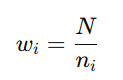

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [9]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [10]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [11]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [12]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [13]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [14]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}


  patiente = 100
  best_recall = 0
  best_precision = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if (val_recall > best_recall) and (val_precision > best_precision):
        best_recall = val_recall
        best_precision = val_precision
        torch.save(model.state_dict(), 'best_model.pt')


  wandb.finish()
  print(best_recall)
  print(best_precision)

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2}
MODEL = architectures['resnet152']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
extra = 0.4
WEIGHTS = [get_weights()+extra]

learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 153MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.8229647861576397]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5034813537242565
Accuracy train epoch: 1  train_acc: 0.8190522243713733
F1 train epoch: 1  train_f1: 0.5806420705514107
Recall train epoch: 1  train_recall: 0.6896909827760892


Pèrdua validació epoch: 1  val_loss: 0.4072752259671688
Accuracy val epoch: 1  val_acc: 0.8609375
F1 val epoch: 1  val_f1: 0.6476399060498328
Recall val epoch: 1  val_recall: 0.6995783730158731
Recall val epoch: 1  val_precision: 0.6267800775613277


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.37281189833549744
Accuracy train epoch: 2  train_acc: 0.8774661508704062
F1 train epoch: 2  train_f1: 0.6937554869823901
Recall train epoch: 2  train_recall: 0.7709922583326843


Pèrdua validació epoch: 2  val_loss: 0.3759233127348125
Accuracy val epoch: 2  val_acc: 0.8814453125
F1 val epoch: 2  val_f1: 0.6554710914085915
Recall val epoch: 2  val_recall: 0.6447420634920635
Recall val epoch: 2  val_precision: 0.7432291666666668


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.30878111320607204
Accuracy train epoch: 3  train_acc: 0.902683752417795
F1 train epoch: 3  train_f1: 0.7497433819062825
Recall train epoch: 3  train_recall: 0.8145436124159525


Pèrdua validació epoch: 3  val_loss: 0.38302005315199494
Accuracy val epoch: 3  val_acc: 0.89921875
F1 val epoch: 3  val_f1: 0.6930584835915719
Recall val epoch: 3  val_recall: 0.6298825306637807
Recall val epoch: 3  val_precision: 0.807886904761905


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.274576710164547
Accuracy train epoch: 4  train_acc: 0.914301257253385
F1 train epoch: 4  train_f1: 0.7782201057620988
Recall train epoch: 4  train_recall: 0.8358760860888522


Pèrdua validació epoch: 4  val_loss: 0.31973788421601057
Accuracy val epoch: 4  val_acc: 0.890234375
F1 val epoch: 4  val_f1: 0.7169956116187735
Recall val epoch: 4  val_recall: 0.7543357683982684
Recall val epoch: 4  val_precision: 0.7069444444444446


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.24414276867470844
Accuracy train epoch: 5  train_acc: 0.9246856866537718
F1 train epoch: 5  train_f1: 0.7967968893164574
Recall train epoch: 5  train_recall: 0.865682674299696


Pèrdua validació epoch: 5  val_loss: 0.33329064992722124
Accuracy val epoch: 5  val_acc: 0.88671875
F1 val epoch: 5  val_f1: 0.7143267126964884
Recall val epoch: 5  val_recall: 0.7578869047619049
Recall val epoch: 5  val_precision: 0.7148675976800976


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.20134356546592205
Accuracy train epoch: 6  train_acc: 0.9406310444874275
F1 train epoch: 6  train_f1: 0.839804725608362
Recall train epoch: 6  train_recall: 0.8987944797519268


Pèrdua validació epoch: 6  val_loss: 0.31411690916866064
Accuracy val epoch: 6  val_acc: 0.8876953125
F1 val epoch: 6  val_f1: 0.7257169208719931
Recall val epoch: 6  val_recall: 0.8094606782106781
Recall val epoch: 6  val_precision: 0.6873895202020203


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.18142732079041765
Accuracy train epoch: 7  train_acc: 0.9435565764023212
F1 train epoch: 7  train_f1: 0.8461496636527644
Recall train epoch: 7  train_recall: 0.9131540091114566


Pèrdua validació epoch: 7  val_loss: 0.36254481016658247
Accuracy val epoch: 7  val_acc: 0.9130859375
F1 val epoch: 7  val_f1: 0.7254861044528226
Recall val epoch: 7  val_recall: 0.6739515692640693
Recall val epoch: 7  val_precision: 0.8381572420634922


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.1573287824208432
Accuracy train epoch: 8  train_acc: 0.9531914893617022
F1 train epoch: 8  train_f1: 0.8732753890233641
Recall train epoch: 8  train_recall: 0.9191476726583115


Pèrdua validació epoch: 8  val_loss: 0.35262679017614573
Accuracy val epoch: 8  val_acc: 0.9029296875
F1 val epoch: 8  val_f1: 0.7366034185113133
Recall val epoch: 8  val_recall: 0.7255332341269842
Recall val epoch: 8  val_precision: 0.775074404761905


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.1379116446334631
Accuracy train epoch: 9  train_acc: 0.9585106382978723
F1 train epoch: 9  train_f1: 0.8863049508586696
Recall train epoch: 9  train_recall: 0.9390488117083863


Pèrdua validació epoch: 9  val_loss: 0.3697739695198834
Accuracy val epoch: 9  val_acc: 0.90625
F1 val epoch: 9  val_f1: 0.7437234138303218
Recall val epoch: 9  val_recall: 0.7372891865079365
Recall val epoch: 9  val_precision: 0.776326884920635


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.12470559125092436
Accuracy train epoch: 10  train_acc: 0.9633704061895552
F1 train epoch: 10  train_f1: 0.8994915323352186
Recall train epoch: 10  train_recall: 0.9371563306669688


Pèrdua validació epoch: 10  val_loss: 0.3821198674850166
Accuracy val epoch: 10  val_acc: 0.9041015625
F1 val epoch: 10  val_f1: 0.7093129227368781
Recall val epoch: 10  val_recall: 0.7014745670995671
Recall val epoch: 10  val_precision: 0.7770078012265513


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.1084913950809773
Accuracy train epoch: 11  train_acc: 0.9667674081237911
F1 train epoch: 11  train_f1: 0.9052483953771752
Recall train epoch: 11  train_recall: 0.9480731325412177


Pèrdua validació epoch: 11  val_loss: 0.3995617984328419
Accuracy val epoch: 11  val_acc: 0.897265625
F1 val epoch: 11  val_f1: 0.7076540424015269
Recall val epoch: 11  val_recall: 0.7374255952380953
Recall val epoch: 11  val_precision: 0.7264384920634921


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.10747273408193538
Accuracy train epoch: 12  train_acc: 0.9675531914893617
F1 train epoch: 12  train_f1: 0.9035244413638458
Recall train epoch: 12  train_recall: 0.947327684136195


Pèrdua validació epoch: 12  val_loss: 0.3846208337927237
Accuracy val epoch: 12  val_acc: 0.901171875
F1 val epoch: 12  val_f1: 0.7304600832174362
Recall val epoch: 12  val_recall: 0.7661086309523811
Recall val epoch: 12  val_precision: 0.7373387896825399


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.09236970533557395
Accuracy train epoch: 13  train_acc: 0.9732833655705996
F1 train epoch: 13  train_f1: 0.9219179217662876
Recall train epoch: 13  train_recall: 0.9583523686715174


Pèrdua validació epoch: 13  val_loss: 0.39065740315709263
Accuracy val epoch: 13  val_acc: 0.9189453125
F1 val epoch: 13  val_f1: 0.7699265035901867
Recall val epoch: 13  val_recall: 0.7606828067765569
Recall val epoch: 13  val_precision: 0.8010044642857144


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.08643798446877206
Accuracy train epoch: 14  train_acc: 0.9746735976789169
F1 train epoch: 14  train_f1: 0.9216929516698966
Recall train epoch: 14  train_recall: 0.9588649412053667


Pèrdua validació epoch: 14  val_loss: 0.41373808216303587
Accuracy val epoch: 14  val_acc: 0.8916015625
F1 val epoch: 14  val_f1: 0.7278473359500838
Recall val epoch: 14  val_recall: 0.7893849206349208
Recall val epoch: 14  val_precision: 0.7072116251803754


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.08960129694735751
Accuracy train epoch: 15  train_acc: 0.9761968085106383
F1 train epoch: 15  train_f1: 0.9305006969258341
Recall train epoch: 15  train_recall: 0.9634246368288922


Pèrdua validació epoch: 15  val_loss: 0.383775366935879
Accuracy val epoch: 15  val_acc: 0.9072265625
F1 val epoch: 15  val_f1: 0.7465181498857592
Recall val epoch: 15  val_recall: 0.7586681547619049
Recall val epoch: 15  val_precision: 0.7658978174603176


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.06252138898807003
Accuracy train epoch: 16  train_acc: 0.9828457446808511
F1 train epoch: 16  train_f1: 0.9533389189838039
Recall train epoch: 16  train_recall: 0.9754573086487982


Pèrdua validació epoch: 16  val_loss: 0.43186399318437907
Accuracy val epoch: 16  val_acc: 0.9150390625
F1 val epoch: 16  val_f1: 0.7666128915911231
Recall val epoch: 16  val_recall: 0.7530877976190478
Recall val epoch: 16  val_precision: 0.8198018127705629


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.07318034993999815
Accuracy train epoch: 17  train_acc: 0.9792553191489362
F1 train epoch: 17  train_f1: 0.940395683662596
Recall train epoch: 17  train_recall: 0.9654592098209122


Pèrdua validació epoch: 17  val_loss: 0.4008566714328481
Accuracy val epoch: 17  val_acc: 0.908203125
F1 val epoch: 17  val_f1: 0.7397469303039957
Recall val epoch: 17  val_recall: 0.7411401966089467
Recall val epoch: 17  val_precision: 0.7751972853535354


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.06901276847347618
Accuracy train epoch: 18  train_acc: 0.9823863636363637
F1 train epoch: 18  train_f1: 0.9468269222579246
Recall train epoch: 18  train_recall: 0.9725284408263133


Pèrdua validació epoch: 18  val_loss: 0.3902289833058603
Accuracy val epoch: 18  val_acc: 0.9140625
F1 val epoch: 18  val_f1: 0.7571454683732161
Recall val epoch: 18  val_recall: 0.7517775627150629
Recall val epoch: 18  val_precision: 0.7929109952547454


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.06320610842073059
Accuracy train epoch: 19  train_acc: 0.9829182785299807
F1 train epoch: 19  train_f1: 0.9423101803953213
Recall train epoch: 19  train_recall: 0.975203968608224


Pèrdua validació epoch: 19  val_loss: 0.3821228305132536
Accuracy val epoch: 19  val_acc: 0.91015625
F1 val epoch: 19  val_f1: 0.7503483893020466
Recall val epoch: 19  val_recall: 0.7834686147186148
Recall val epoch: 19  val_precision: 0.750843253968254


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.06315971363851047
Accuracy train epoch: 20  train_acc: 0.9823863636363637
F1 train epoch: 20  train_f1: 0.947016122632683
Recall train epoch: 20  train_recall: 0.9739826839826842


Pèrdua validació epoch: 20  val_loss: 0.3667023620510008
Accuracy val epoch: 20  val_acc: 0.912109375
F1 val epoch: 20  val_f1: 0.7465049605215048
Recall val epoch: 20  val_recall: 0.7487351190476191
Recall val epoch: 20  val_precision: 0.7841145833333334


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.051047080754242996
Accuracy train epoch: 21  train_acc: 0.9870406189555126
F1 train epoch: 21  train_f1: 0.9602818244633673
Recall train epoch: 21  train_recall: 0.9823923121795463


Pèrdua validació epoch: 21  val_loss: 0.3917702895705588
Accuracy val epoch: 21  val_acc: 0.9080078125
F1 val epoch: 21  val_f1: 0.7356733042177123
Recall val epoch: 21  val_recall: 0.7624481421356424
Recall val epoch: 21  val_precision: 0.7645540223665225


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.04995558286541479
Accuracy train epoch: 22  train_acc: 0.9860372340425532
F1 train epoch: 22  train_f1: 0.9600143931884989
Recall train epoch: 22  train_recall: 0.982254010764649


Pèrdua validació epoch: 22  val_loss: 0.41027046425733715
Accuracy val epoch: 22  val_acc: 0.9021484375
F1 val epoch: 22  val_f1: 0.7227054338098263
Recall val epoch: 22  val_recall: 0.7401537698412699
Recall val epoch: 22  val_precision: 0.764232729076479


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.05825857764625169
Accuracy train epoch: 23  train_acc: 0.9840425531914894
F1 train epoch: 23  train_f1: 0.952507335627454
Recall train epoch: 23  train_recall: 0.9780441190015657


Pèrdua validació epoch: 23  val_loss: 0.47215481218881905
Accuracy val epoch: 23  val_acc: 0.9146484375
F1 val epoch: 23  val_f1: 0.7271502671197914
Recall val epoch: 23  val_recall: 0.6937691648629151
Recall val epoch: 23  val_precision: 0.8458333333333334


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.03917526349603654
Accuracy train epoch: 24  train_acc: 0.9893617021276596
F1 train epoch: 24  train_f1: 0.9645242378834057
Recall train epoch: 24  train_recall: 0.9879882410733474


Pèrdua validació epoch: 24  val_loss: 0.47864873595244717
Accuracy val epoch: 24  val_acc: 0.9158203125
F1 val epoch: 24  val_f1: 0.748443096184002
Recall val epoch: 24  val_recall: 0.7072037337662339
Recall val epoch: 24  val_precision: 0.8385281385281387


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.03883059143504881
Accuracy train epoch: 25  train_acc: 0.9895672147001935
F1 train epoch: 25  train_f1: 0.9676231614011738
Recall train epoch: 25  train_recall: 0.9862573596616152


Pèrdua validació epoch: 25  val_loss: 0.42800450986396754
Accuracy val epoch: 25  val_acc: 0.91484375
F1 val epoch: 25  val_f1: 0.7512071568137745
Recall val epoch: 25  val_recall: 0.730736797924298
Recall val epoch: 25  val_precision: 0.8385788690476191


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.04642656544976412
Accuracy train epoch: 26  train_acc: 0.9858438104448743
F1 train epoch: 26  train_f1: 0.9548480116667325
Recall train epoch: 26  train_recall: 0.9794674710632161


Pèrdua validació epoch: 26  val_loss: 0.42128126436728053
Accuracy val epoch: 26  val_acc: 0.9158203125
F1 val epoch: 26  val_f1: 0.7295546467421469
Recall val epoch: 26  val_recall: 0.7399925595238096
Recall val epoch: 26  val_precision: 0.7943824404761907


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.04047131654707358
Accuracy train epoch: 27  train_acc: 0.9886968085106383
F1 train epoch: 27  train_f1: 0.9662145872318485
Recall train epoch: 27  train_recall: 0.9837633170611894


Pèrdua validació epoch: 27  val_loss: 0.414822657359764
Accuracy val epoch: 27  val_acc: 0.908984375
F1 val epoch: 27  val_f1: 0.7092761450902899
Recall val epoch: 27  val_recall: 0.6831067370129872
Recall val epoch: 27  val_precision: 0.8204613095238097


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.03808090170211297
Accuracy train epoch: 28  train_acc: 0.9913563829787234
F1 train epoch: 28  train_f1: 0.9698413433919348
Recall train epoch: 28  train_recall: 0.9877397071014092


Pèrdua validació epoch: 28  val_loss: 0.49710968893487006
Accuracy val epoch: 28  val_acc: 0.91796875
F1 val epoch: 28  val_f1: 0.7725060027691607
Recall val epoch: 28  val_recall: 0.7399925595238095
Recall val epoch: 28  val_precision: 0.846279761904762


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.04309640191396342
Accuracy train epoch: 29  train_acc: 0.9882978723404255
F1 train epoch: 29  train_f1: 0.964145353105272
Recall train epoch: 29  train_recall: 0.9888415603309222


Pèrdua validació epoch: 29  val_loss: 0.47186523652635515
Accuracy val epoch: 29  val_acc: 0.9169921875
F1 val epoch: 29  val_f1: 0.7571190380289646
Recall val epoch: 29  val_recall: 0.7272693452380952
Recall val epoch: 29  val_precision: 0.8238009386446886


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.03317992000721712
Accuracy train epoch: 30  train_acc: 0.9925531914893617
F1 train epoch: 30  train_f1: 0.9719573558270962
Recall train epoch: 30  train_recall: 0.9900673912376039


Pèrdua validació epoch: 30  val_loss: 0.4953169412910938
Accuracy val epoch: 30  val_acc: 0.9107421875
F1 val epoch: 30  val_f1: 0.726025755645321
Recall val epoch: 30  val_recall: 0.7081574675324674
Recall val epoch: 30  val_precision: 0.8013607052669554


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.03698328206999267
Accuracy train epoch: 31  train_acc: 0.9897606382978723
F1 train epoch: 31  train_f1: 0.9674761317284867
Recall train epoch: 31  train_recall: 0.9825581038346997


Pèrdua validació epoch: 31  val_loss: 0.38113443268230185
Accuracy val epoch: 31  val_acc: 0.91015625
F1 val epoch: 31  val_f1: 0.774105562319088
Recall val epoch: 31  val_recall: 0.8549828643578643
Recall val epoch: 31  val_precision: 0.7277608676046177


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.031048383855042938
Accuracy train epoch: 32  train_acc: 0.9913563829787234
F1 train epoch: 32  train_f1: 0.9728066045746039
Recall train epoch: 32  train_recall: 0.9904490190660404


Pèrdua validació epoch: 32  val_loss: 0.5508221990603488
Accuracy val epoch: 32  val_acc: 0.9119140625
F1 val epoch: 32  val_f1: 0.7387661862990812
Recall val epoch: 32  val_recall: 0.698941423160173
Recall val epoch: 32  val_precision: 0.8184771825396826


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.03168715734624284
Accuracy train epoch: 33  train_acc: 0.9924927466150871
F1 train epoch: 33  train_f1: 0.9696099901313658
Recall train epoch: 33  train_recall: 0.9899570169782936


Pèrdua validació epoch: 33  val_loss: 0.48043947853147984
Accuracy val epoch: 33  val_acc: 0.90703125
F1 val epoch: 33  val_f1: 0.7514939462090198
Recall val epoch: 33  val_recall: 0.7788318452380951
Recall val epoch: 33  val_precision: 0.7718986742424243


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.02973758909167682
Accuracy train epoch: 34  train_acc: 0.9925531914893617
F1 train epoch: 34  train_f1: 0.9763348310332384
Recall train epoch: 34  train_recall: 0.9900473403664893


Pèrdua validació epoch: 34  val_loss: 0.5004580402455758
Accuracy val epoch: 34  val_acc: 0.912109375
F1 val epoch: 34  val_f1: 0.7354276023683919
Recall val epoch: 34  val_recall: 0.724238782051282
Recall val epoch: 34  val_precision: 0.8175583964646465


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.03046005088538724
Accuracy train epoch: 35  train_acc: 0.9909574468085106
F1 train epoch: 35  train_f1: 0.9695801883381095
Recall train epoch: 35  train_recall: 0.9885638238829728


Pèrdua validació epoch: 35  val_loss: 0.47358638608830006
Accuracy val epoch: 35  val_acc: 0.91015625
F1 val epoch: 35  val_f1: 0.7165661085238293
Recall val epoch: 35  val_recall: 0.706117406898657
Recall val epoch: 35  val_precision: 0.7810887896825397


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.030787548140939723
Accuracy train epoch: 36  train_acc: 0.9915618955512573
F1 train epoch: 36  train_f1: 0.9730015550178913
Recall train epoch: 36  train_recall: 0.9863361579319024


Pèrdua validació epoch: 36  val_loss: 0.5016714532393962
Accuracy val epoch: 36  val_acc: 0.9001953125
F1 val epoch: 36  val_f1: 0.7286883666406694
Recall val epoch: 36  val_recall: 0.7623669733044732
Recall val epoch: 36  val_precision: 0.72452876984127


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.03624150323349626
Accuracy train epoch: 37  train_acc: 0.9917553191489362
F1 train epoch: 37  train_f1: 0.9719669666297033
Recall train epoch: 37  train_recall: 0.988799144118293


Pèrdua validació epoch: 37  val_loss: 0.5474614382255822
Accuracy val epoch: 37  val_acc: 0.917578125
F1 val epoch: 37  val_f1: 0.7510132631601285
Recall val epoch: 37  val_recall: 0.7374379960317462
Recall val epoch: 37  val_precision: 0.8016121031746034


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.03705534699219378
Accuracy train epoch: 38  train_acc: 0.9895067698259188
F1 train epoch: 38  train_f1: 0.966917459631679
Recall train epoch: 38  train_recall: 0.9864991863928034


Pèrdua validació epoch: 38  val_loss: 0.46638387558050454
Accuracy val epoch: 38  val_acc: 0.9146484375
F1 val epoch: 38  val_f1: 0.7665881045017074
Recall val epoch: 38  val_recall: 0.76789078976579
Recall val epoch: 38  val_precision: 0.8098958333333334


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.024259079351000724
Accuracy train epoch: 39  train_acc: 0.9944148936170213
F1 train epoch: 39  train_f1: 0.9810697889891621
Recall train epoch: 39  train_recall: 0.9924027036792996


Pèrdua validació epoch: 39  val_loss: 0.49123377171054017
Accuracy val epoch: 39  val_acc: 0.91796875
F1 val epoch: 39  val_f1: 0.7751014451986785
Recall val epoch: 39  val_recall: 0.7683159722222225
Recall val epoch: 39  val_precision: 0.8215649801587301


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.029162639386684414
Accuracy train epoch: 40  train_acc: 0.9913563829787234
F1 train epoch: 40  train_f1: 0.9718548227493617
Recall train epoch: 40  train_recall: 0.9869924165668849


Pèrdua validació epoch: 40  val_loss: 0.4217481264786329
Accuracy val epoch: 40  val_acc: 0.9208984375
F1 val epoch: 40  val_f1: 0.7661652685549746
Recall val epoch: 40  val_recall: 0.7746753246753246
Recall val epoch: 40  val_precision: 0.8109002976190476


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.023220635205259587
Accuracy train epoch: 41  train_acc: 0.99375
F1 train epoch: 41  train_f1: 0.9771094933572061
Recall train epoch: 41  train_recall: 0.9919549599336833


Pèrdua validació epoch: 41  val_loss: 0.47402975417207927
Accuracy val epoch: 41  val_acc: 0.92578125
F1 val epoch: 41  val_f1: 0.7987610890571418
Recall val epoch: 41  val_recall: 0.7894717261904762
Recall val epoch: 41  val_precision: 0.845589826839827


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.02281554079827595
Accuracy train epoch: 42  train_acc: 0.9933510638297872
F1 train epoch: 42  train_f1: 0.9766943542581855
Recall train epoch: 42  train_recall: 0.9901835989070031


Pèrdua validació epoch: 42  val_loss: 0.4651048530358821
Accuracy val epoch: 42  val_acc: 0.9111328125
F1 val epoch: 42  val_f1: 0.7668754150154113
Recall val epoch: 42  val_recall: 0.7983822601010103
Recall val epoch: 42  val_precision: 0.7658482142857145


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.02646319990596199
Accuracy train epoch: 43  train_acc: 0.993218085106383
F1 train epoch: 43  train_f1: 0.9768223017802444
Recall train epoch: 43  train_recall: 0.9896332627183693


Pèrdua validació epoch: 43  val_loss: 0.5068043037317693
Accuracy val epoch: 43  val_acc: 0.909765625
F1 val epoch: 43  val_f1: 0.7595998716088695
Recall val epoch: 43  val_recall: 0.7504216269841273
Recall val epoch: 43  val_precision: 0.7991195436507939


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.031188395319065632
Accuracy train epoch: 44  train_acc: 0.9904980657640232
F1 train epoch: 44  train_f1: 0.9683927954223063
Recall train epoch: 44  train_recall: 0.9854589972675081


Pèrdua validació epoch: 44  val_loss: 0.491444103885442
Accuracy val epoch: 44  val_acc: 0.91875
F1 val epoch: 44  val_f1: 0.7692001013692191
Recall val epoch: 44  val_recall: 0.766889880952381
Recall val epoch: 44  val_precision: 0.8118303571428572


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.019379545559863896
Accuracy train epoch: 45  train_acc: 0.9948138297872341
F1 train epoch: 45  train_f1: 0.9857062781824341
Recall train epoch: 45  train_recall: 0.9928758239396538


Pèrdua validació epoch: 45  val_loss: 0.4589063552848529
Accuracy val epoch: 45  val_acc: 0.919921875
F1 val epoch: 45  val_f1: 0.7907287004253918
Recall val epoch: 45  val_recall: 0.7701467803030303
Recall val epoch: 45  val_precision: 0.8318305826118326


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.021276541822589933
Accuracy train epoch: 46  train_acc: 0.995345744680851
F1 train epoch: 46  train_f1: 0.9854669001000943
Recall train epoch: 46  train_recall: 0.9917024937237705


Pèrdua validació epoch: 46  val_loss: 0.5409517153748311
Accuracy val epoch: 46  val_acc: 0.9099609375
F1 val epoch: 46  val_f1: 0.7487244628329189
Recall val epoch: 46  val_recall: 0.7416933760683763
Recall val epoch: 46  val_precision: 0.7883928571428576


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.024781910119518795
Accuracy train epoch: 47  train_acc: 0.9936170212765958
F1 train epoch: 47  train_f1: 0.9809854484409204
Recall train epoch: 47  train_recall: 0.9917067329833287


Pèrdua validació epoch: 47  val_loss: 0.5523021810076898
Accuracy val epoch: 47  val_acc: 0.9140625
F1 val epoch: 47  val_f1: 0.7339989310117987
Recall val epoch: 47  val_recall: 0.7277545371295373
Recall val epoch: 47  val_precision: 0.7745039682539684


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.023639578188700165
Accuracy train epoch: 48  train_acc: 0.9930851063829788
F1 train epoch: 48  train_f1: 0.9779090008050896
Recall train epoch: 48  train_recall: 0.9894698800017948


Pèrdua validació epoch: 48  val_loss: 0.5526839669328183
Accuracy val epoch: 48  val_acc: 0.908984375
F1 val epoch: 48  val_f1: 0.745837388714227
Recall val epoch: 48  val_recall: 0.7357266865079366
Recall val epoch: 48  val_precision: 0.8020461309523809


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.02689952217525446
Accuracy train epoch: 49  train_acc: 0.9929521276595744
F1 train epoch: 49  train_f1: 0.9789315066068245
Recall train epoch: 49  train_recall: 0.9894020282318153


Pèrdua validació epoch: 49  val_loss: 0.5453278504428454
Accuracy val epoch: 49  val_acc: 0.92265625
F1 val epoch: 49  val_f1: 0.7691004308191811
Recall val epoch: 49  val_recall: 0.7452876984126985
Recall val epoch: 49  val_precision: 0.8414806547619048


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.021080768164346352
Accuracy train epoch: 50  train_acc: 0.9948863636363637
F1 train epoch: 50  train_f1: 0.9843853222864173
Recall train epoch: 50  train_recall: 0.994212950170397


Pèrdua validació epoch: 50  val_loss: 0.45197046792600304
Accuracy val epoch: 50  val_acc: 0.9228515625
F1 val epoch: 50  val_f1: 0.7646460721296249
Recall val epoch: 50  val_recall: 0.7483506944444445
Recall val epoch: 50  val_precision: 0.820808531746032


train/train_acc,▁▃▄▅▅▆▇▇▇▇▇▇█▇▇▇████████████████████████
train/train_f1,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇██▇█▇███████████████████
train/train_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████████████████
train/train_recall,▁▃▄▄▅▆▆▇▇▇▇▇▇█▇█████████████████████████
val/val_acc,▁▃▅▄▄▇▆▆▅▅▄▆▇▆▇▇▆▅▇▇▇▆▇▇▆▇▆▇▆▅▇▇▇█▆▇▇▆▇█
val/val_f1,▁▁▃▄▄▅▅▅▄▄▇▅▆▇▅▆▅▄▅▆▅▄▇▆▅▅▆▅▄▅▇▇▆█▇█▆▅▆▆
val/val_loss,▄▃▃▁▁▂▂▃▃▃▃▄▃▄▃▃▂▃▄▆▄▄▄▆▆▃█▆▆▆▅▆▄▆▇▅███▅
val/val_precision,▁▅▇▄▄█▆▆▄▅▄▅▇▆▆▆▅▅██▆▇▇▇▄▆▇▆▄▇▇▇█▅▇█▆▆▇▇
val/val_recall,▃▁▁▅▅▂▄▄▃▄▅▆▅▅▄▆▅▅▄▃▄▄▃▄█▆▄▃▅▄▅▆▆▆▅▅▄▄▄▅
train/train_acc,0.99489


In [16]:
print(training.__len__())

NameError: name 'training' is not defined

NameError: name 'best_recall' is not defined